In [1]:

import pathlib
import glob
import os
import collections
import json
from omegaconf import OmegaConf

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object, check_common_attrs
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import round_n, set_intervals
set_plot_params()

from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"
import argparse

def parse_args():
    parser = argparse.ArgumentParser()
    # parser.add_argument("--infer", action="store_true", help="Inference mode")
    parser.add_argument("--train", action="store_true", default=False, help="Train mode")
    parser.add_argument("--infer", action="store_true", default=False, help="Inference mode")    
    parser.add_argument("--finetune", action="store_true", default=False, help="Finetune")
    parser.add_argument("--pdata", type=float, default=None, help="Proportion of data to finetune on")
    parser.add_argument("--dataset", type=str, default="first", help="Dataset")
    parser.add_argument("--dist", action="store_true", default=False, help="Distrinuted training")
    parser.add_argument("--resume", type=str, default=None, help="Resume from checkpoint")
    parser.add_argument("--rand_perm", action="store_true", default=False, help="Randomly permute the ID column")
    parser.add_argument("--mconf", type=str, default=None, help="Path to model config file")
    parser.add_argument("--downstream", action="store_true", default=False, help="Downstream task")
    parser.add_argument("--freeze_model", action="store_true", default=False, help="Freeze model")
    parser.add_argument("--title", type=str, default=None)
    parser.add_argument("--seed", type=int, default=25)
    parser.add_argument("--behavior", action="store_true", default=False, help="Behavior task")
    parser.add_argument("--predict_behavior", action="store_true", default=False, help="Predict behavior")
    # parser.add_argument("--behavior_vars", type=str, default=None, help="Behavior variables")
    parser.add_argument("--behavior_vars", nargs='+', default=None, help="Behavior variables")
    parser.add_argument("--round_vars", action="store_true", default=False, help="Round variables")
    parser.add_argument("--past_state", action="store_true", default=False, help="Input past state")
    parser.add_argument("--visual", action="store_true", default=False, help="Visualize")
    parser.add_argument("--contrastive", action="store_true", default=False, help="Contrastive")
    parser.add_argument("--local_rank", type=int, default=0)
    parser.add_argument("--fuse_stim_behavior", action="store_true", default=False, help="Fuse stimulus and behavior")
    return parser.parse_args()

# if __name__ == "__main__":
#     args = parse_args()
#     INFERENCE = not args.train
# else:
#     INFERENCE = True

# check if jupyter notebook

try:
    shell = get_ipython().__class__.__name__
    print("Running in Jupyter notebook")
    TRAIN = False
    FINETUNE = False
    PDATA = 0.1
    INFERENCE = True
    DATASET = "lateral"
    DIST = False
    DOWNSTREAM = False
    RESUME = None
    RAND_PERM = False
    MCONF = "./configs/visnav/lateral_speed_predict/mconf.yaml"
    FREEZE_MODEL = False
    TITLE = None
    SEED = 25
    BEHAVIOR = True
    PREDICT_BEHAVIOR = True
    BEHAVIOR_VARS = ['speed']
    ROUND_VARS = False
    PAST_STATE = True
    VISUAL = True
    CONTRASTIVE = False
    FUSE_STIM_BEHAVIOR = False
except:
    print("Running in terminal")
    args = parse_args()
    TRAIN = args.train
    FINETUNE = args.finetune
    PDATA = args.pdata
    INFERENCE = args.infer
    DATASET = args.dataset
    DIST = args.dist
    DOWNSTREAM = args.downstream
    RESUME = args.resume
    RAND_PERM = args.rand_perm
    MCONF = args.mconf
    FREEZE_MODEL = args.freeze_model
    TITLE = args.title
    SEED = args.seed
    BEHAVIOR = args.behavior
    PREDICT_BEHAVIOR = args.predict_behavior
    BEHAVIOR_VARS = args.behavior_vars
    ROUND_VARS = args.round_vars
    PAST_STATE = args.past_state
    VISUAL = args.visual
    CONTRASTIVE = args.contrastive
    FUSE_STIM_BEHAVIOR = args.fuse_stim_behavior
    
set_seed(25)

print(f" // CONTRASTIVE: {CONTRASTIVE} //")
print(f" // VISUAL: {VISUAL} //")
print(f" // PAST_STATE: {PAST_STATE} //")
print(f" // PREDICT_BEHAVIOR: {PREDICT_BEHAVIOR} //")
print(f" // BEHAVIOR: {BEHAVIOR} //")
print(f" // FUSE_STIM_BEHAVIOR: {FUSE_STIM_BEHAVIOR} //")

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)


Running in Jupyter notebook
 // CONTRASTIVE: False //
 // VISUAL: True //
 // PAST_STATE: True //
 // PREDICT_BEHAVIOR: True //
 // BEHAVIOR: True //
 // FUSE_STIM_BEHAVIOR: False //


In [2]:
from neuroformer.prepare_data import DataLinks

ds = "LateralVRDataset"
ds = "MedialVRDataset"
ds = "VisNav_VR_Expt"
data_dir = f"data/VisNav_VR_Expt/"
DATA_POINTERS = getattr(DataLinks, ds)

if not os.path.exists(data_dir):
    print("Downloading data...")
    import gdown
    url = DATA_POINTERS['url']
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output=DATA_POINTERS['DIRECTORY'])

In [3]:
# load config files
import yaml

# base_path = "configs/visnav/predict_behavior"
base_path = "./configs/visnav/lateral_phi_th/better_kernel" if MCONF is None else os.path.dirname(MCONF)

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)

In [4]:
import mat73

# data_path = DATA_POINTERS['RESPONSE_PATH']
if DATASET in ["first", "visnav"]:
    data_path = "./data/VisNav_VR_Expt"
elif DATASET == "medial":
    data_path = "./data/VisNav_VR_Expt/MedialVRDataset/"
elif DATASET == "lateral":
    data_path = "./data/VisNav_VR_Expt/LateralVRDataset"

print(f"Loading data from {data_path}")
# stimulus = np.load(os.path.join(data_path, "stimulus.npy"), allow_pickle=True)
# response = np.load(os.path.join(data_path, "response.npy"), allow_pickle=True)
# trial_data = np.load(os.path.join(data_path, "trial_data.npy"), allow_pickle=True)
data = mat73.loadmat(os.path.join(data_path, "experiment_data.mat"))['neuroformer']

# data_response_path = "/data5/antonis/neuroformer/data/VisNav_VR_Expt/yiyi/experiment_data_selected.mat"
# data_response = scipy.io.loadmat(data_response_path)
# neurons_sel1 = "./data/VisNav_VR_Expt/yiyi/sel1.csv"
# neurons_sel1 = pd.read_csv(neurons_sel1)
# neurons_sel1 = np.array(neurons_sel1).flatten()



Loading data from ./data/VisNav_VR_Expt/LateralVRDataset


In [5]:
if INFERENCE or FINETUNE or TRAIN:
    window = mconf.window
    window_prev = mconf.window_prev
    frame_window = mconf.frame_window
    window_behavior = mconf.window_behavior if hasattr(mconf, 'window_behavior') else None
    dt = mconf.dt
    dt_frames = mconf.dt_frames if hasattr(mconf, 'dt_frames') else 0.05
    dt_vars = mconf.dt_vars if hasattr(mconf, 'dt_vars') else 0.05
    dt_speed = mconf.dt_speed if hasattr(mconf, 'dt_speed') else 0.2
    intervals = None
else:
    window = 0.05
    window_prev = 0.25
    frame_window = window + window_prev
    window_behavior = window
    dt = 0.005
    dt_frames = 0.05
    dt_vars = 0.05
    dt_speed = 0.2
    intervals = None

# set attrs that are not equal
common_attrs = check_common_attrs(mconf, tconf, dconf)
print(f"Common attributes: {common_attrs}")

Common attributes: {}


In [6]:
## choose modalities ##

# behavior
behavior = BEHAVIOR
# behavior_vars = ['t', 'eyerad', 'phi', 'speed', 'th']
behavior_vars = ['speed'] if BEHAVIOR_VARS is None else BEHAVIOR_VARS
n_behavior = len(behavior_vars)
predict_behavior = PREDICT_BEHAVIOR
# stimulus
visual_stim = VISUAL

print(f" // using behavior vars: {BEHAVIOR_VARS} //")

 // using behavior vars: ['speed'] //


In [33]:
data['spiketimes'].keys()

dict_keys(['spks'])

In [7]:
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals, set_trials

stimulus = data['vid_sm']
response = data['spiketimes']['spks']
trial_data = data['trialsummary']
# response = data_response['spiketime_sel2']['spks']

print(data.keys())

df = get_df_visnav(response, trial_data, dt_vars)
# df = df[df['ID'].isin(neurons_sel1)].reset_index(drop=True)

if behavior or predict_behavior is True:
    df_behavior = pd.DataFrame({k: data[k] for k in behavior_vars + ['t']})
    # rename t to time
    df_behavior = df_behavior.rename(columns={'t': 'Time'}) if df_behavior is not None else None
    df_behavior = set_trials(df_behavior, trial_data) 
    df_behavior['Interval'] = make_intervals(df_behavior, window)
    df_behavior['Interval_2'] = make_intervals(df_behavior, window_prev)

    # prepare speed variables
    if 'speed' in df_behavior.columns:
        df_behavior['speed'] = df_behavior['speed'].apply(lambda x: round_n(x, dt_speed))
        dt_range_speed = df_behavior['speed'].min(), df_behavior['speed'].max()
        dt_range_speed = np.arange(dt_range_speed[0], dt_range_speed[1] + dt_speed, dt_speed)
        n_behavior = len(dt_range_speed)
        stoi_speed = { round_n(ch, dt_speed):i for i,ch in enumerate(dt_range_speed) }
        itos_speed = { i:round_n(ch, dt_speed) for i,ch in enumerate(dt_range_speed) }
    else:
        n_behavior = None
        stoi_speed = None
        itos_speed = None
        assert predict_behavior is False
    
    if ROUND_VARS:
        print(f" // ROUNDING behavior vars to {dt} //")
        dt_phi = 0.2
        dt_th = 0.2
        df_behavior['phi'] = df_behavior['phi'].apply(lambda x: round_n(x, dt_phi))
        df_behavior['th'] = df_behavior['th'].apply(lambda x: round_n(x, dt_th))

        # prepare phi variables
        dt_range_phi = df_behavior['phi']
        dt_range_phi = np.arange(dt_range_phi[0], dt_range_phi[1] + dt_phi, dt_phi)
        stoi_phi = { round_n(ch, dt_phi):i for i,ch in enumerate(dt_range_phi) }
        itos_phi = { i:round_n(ch, dt_phi) for i,ch in enumerate(dt_range_phi) }

        # prepare th variables
        dt_range_th =  df_behavior['th']
        dt_range_th = np.arange(dt_range_th[0], dt_range_th[1] + dt_th, dt_th)
        stoi_th = { round_n(ch, dt_th):i for i,ch in enumerate(dt_range_th) }
        itos_th = { i:round_n(ch, dt_th) for i,ch in enumerate(dt_range_th) }

    # assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
    samples_per_behavior = int((window + window_prev) // dt_vars)
    behavior_block_size = int((window + window_prev) // dt_vars) * (len(df_behavior.columns) - 1)
else:
    behavior = False 
    df_behavior = None
    behavior_vars = None
    behavior_block_size = 0
    samples_per_behavior = 0
    stoi_speed = None
    itos_speed = None
    dt_range_speed = None
    n_behavior = None
    stoi_phi = None
    itos_phi = None
    dt_range_phi = None
    stoi_th = None
    itos_th = None
    dt_range_th = None


dict_keys(['eyerad', 'phi', 'rewards', 'speed', 'spiketimes', 't', 'th', 'trialsummary', 'vid_sm'])


In [8]:
from neuroformer.SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']


In [11]:
timesteps = 5000
neurons = 50
out_dim = 8

neural_data = np.random.normal(0,1,(timesteps, neurons))
continuous_label = np.random.normal(0,1,(timesteps, 3))
discrete_label = np.random.randint(0,10,(timesteps,))

print(f"neural_data: {neural_data.shape}")
print(f"continuous_label: {continuous_label.shape}")
print(f"discrete_label: {discrete_label.shape}")

neural_data: (5000, 50)
continuous_label: (5000, 3)
discrete_label: (5000,)


In [17]:
len(response)

2023

In [22]:
np.array(response[0]).shape

(1, 399)

In [23]:
np.array(response[1]).shape

(1, 862)

In [18]:
response_arr = np.array(response)

/tmp/ipykernel_3730430/2371499772.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  response_arr = np.array(response)


In [24]:

# Assuming your spike_timing array and total time T are defined
# spike_timing = np.array(...)
T = 2000
spike_timing = np.array(response[1]).shape
# Define the number of bins you want
n_bins = 100

# Define the bin edges based on your total time and number of bins
bin_edges = np.linspace(0, T, n_bins + 1)

# Use np.histogram to count the number of spikes in each bin
binned_spikes, _ = np.histogram(spike_timing, bins=bin_edges)

# Now binned_spikes is your binned array

In [26]:
binned_spikes.shape

(100,)

In [28]:
neural_data[0]

array([ 1.0773015 , -0.51925529,  0.75041971, -0.22007128,  1.41588488,
        0.80173871,  1.60427959,  2.24418099, -0.5254622 ,  1.41250099,
       -0.87336971,  0.27327569,  0.82822315,  0.12611605,  0.57232975,
        1.58551659, -0.76688454,  0.65595971, -1.81331292,  0.40116354,
       -0.44835895, -2.20642503,  2.14457174,  2.32605392,  0.1943061 ,
       -0.29499731, -1.40358481,  0.87761795,  0.96148514,  0.2152542 ,
       -1.56374442, -0.07708393, -0.28380374,  0.70805423, -2.18593641,
       -1.04323245,  0.65534022,  2.14275766, -1.09237458,  2.36544017,
        2.68103187, -0.33819967, -0.60784245,  0.70248771, -0.55131239,
        1.80298554,  0.35570416,  1.50101774,  2.96436655, -0.90982313])

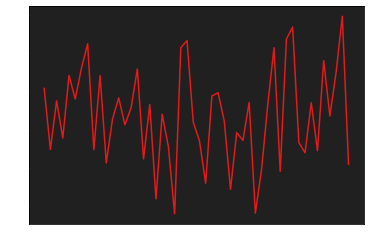

In [30]:
plt.plot(neural_data[0])

In [9]:
from sklearn.model_selection import train_test_split
import cebra

# Load the .npz
neural_data = cebra.load_data(file="neural_data.npz", key="neural")

# ... and similarly load the .h5 file, providing the columns to keep
continuous_label = cebra.load_data(file="auxiliary_behavior_data.h5", key="auxiliary_variables", columns=["continuous1", "continuous2", "continuous3"])
discrete_label = cebra.load_data(file="auxiliary_behavior_data.h5", key="auxiliary_variables", columns=["discrete"]).flatten()


# 1. Train a CEBRA-Time model on the whole dataset
cebra_model = cebra.CEBRA(max_iterations=10)
cebra_model.fit(neural_data)
embedding = cebra_model.transform(neural_data)

# 2. Split the embedding and label to decode into train/validation sets
(
     train_embedding,
     valid_embedding,
     train_discrete_label,
     valid_discrete_label,
) = train_test_split(embedding,
                     discrete_label,
                     test_size=0.3)

# 3. Train the decoder on the training set
decoder = cebra.KNNDecoder()
decoder.fit(train_embedding, train_discrete_label)

# 4. Get the score on the validation set
score = decoder.score(valid_embedding, valid_discrete_label)

# 5. Get the discrete labels predictions
prediction = decoder.predict(valid_embedding)

FileNotFoundError: [Errno 2] No such file or directory: 'neural_data.npz'

In [ ]:
import cebra

# Load the .npz
neural_data = cebra.load_data(file="neural_data.npz", key="neural")

# ... and similarly load the .h5 file, providing the columns to keep
continuous_label = cebra.load_data(file="auxiliary_behavior_data.h5", key="auxiliary_variables", columns=["continuous1", "continuous2", "continuous3"])
discrete_label = cebra.load_data(file="auxiliary_behavior_data.h5", key="auxiliary_variables", columns=["discrete"]).flatten()

ModuleNotFoundError: No module named 'cebra'